In [1]:
import pandas as pd
import numpy as np
import glob
import os

file_paths = sorted(glob.glob('papaya_data/*.csv'))
all_data = []

for file in file_paths:
    df = pd.read_csv(file)
    if 'Back' in df.iloc[:, -1].unique():
        df = df[df.iloc[:, -1] != 'Back']
    all_data.append(df)

data_all = pd.concat(all_data, axis=0).reset_index(drop=True)
print(f"전체 시점 수 (Back 제거 후): {len(data_all)}")


전체 시점 수 (Back 제거 후): 10685


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔹 방향각의 변화량 (delta azimuth) 추가
azimuth_rad = np.radians(data_all['azimuth'])
delta_azimuth = np.diff(azimuth_rad, prepend=azimuth_rad.iloc[0])
delta_azimuth = (delta_azimuth + np.pi) % (2 * np.pi) - np.pi  # [-π, π] 범위로 정규화
data_all['dAzimuth'] = delta_azimuth

# 🔹 sin, cos 변환
data_all['azimuth_sin'] = np.sin(azimuth_rad)
data_all['azimuth_cos'] = np.cos(azimuth_rad)

# 🔹 가속도 변화량
for axis in ['X', 'Y', 'Z']:
    col = f'accel{axis}'
    dcol = f'dAccel{axis}'
    data_all[dcol] = data_all[col].diff().fillna(0)

# 🔹 정규화 대상 선정
exclude_cols = ['timestamp', 'timestamp_offset', 'direction', 'azimuth']
feature_cols = [col for col in data_all.columns if col not in exclude_cols]

# 🔹 정규화
scaler = StandardScaler()
data_all[feature_cols] = scaler.fit_transform(data_all[feature_cols])

# 🔹 사용하지 않는 열 제거
data_all = data_all.drop(columns=['timestamp', 'timestamp_offset', 'azimuth'])
data_all = data_all[[col for col in data_all.columns if col != 'direction'] + ['direction']]

In [3]:
from sklearn.preprocessing import LabelEncoder

window_size = 5
X_all, y_all = [], []

label_encoder = LabelEncoder()
label_encoder.fit(data_all['direction'].astype(str))
print("클래스 매핑:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

for i in range(len(data_all) - window_size + 1):
    window = data_all.iloc[i:i+window_size]
    features = window.iloc[:, :-1].values.astype(np.float32)
    label_mode_str = window['direction'].mode()[0]
    label_encoded = label_encoder.transform([label_mode_str])[0]
    X_all.append(features)
    y_all.append(label_encoded)

X_all = np.array(X_all)
y_all = np.array(y_all)


클래스 매핑: {'Front': 0, 'Left': 1, 'Right': 2, 'Stay': 3}


In [4]:
from sklearn.model_selection import StratifiedKFold

X_flat = X_all.reshape(X_all.shape[0], -1)
y_flat = y_all.copy()

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(X_flat, y_flat))

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
CM_total = np.zeros((len(label_encoder.classes_), len(label_encoder.classes_)), dtype=int)
preds_all, targets_all = [], []



===== Fold 0 =====
Fold 0 best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

       Front     0.9121    0.9695    0.9399      1541
        Left     0.8824    0.6897    0.7742       174
       Right     0.8889    0.7308    0.8021       208
        Stay     0.8646    0.7757    0.8177       214

    accuracy                         0.9041      2137
   macro avg     0.8870    0.7914    0.8335      2137
weighted avg     0.9027    0.9041    0.9008      2137



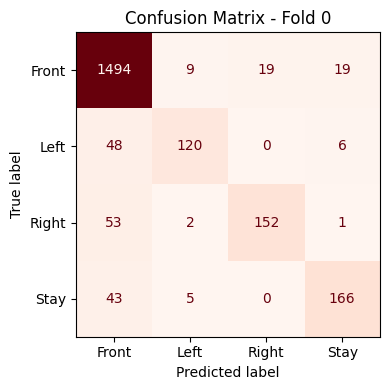


===== Fold 1 =====
Fold 1 best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

       Front     0.9073    0.9591    0.9325      1541
        Left     0.9098    0.6994    0.7908       173
       Right     0.8800    0.6346    0.7374       208
        Stay     0.7902    0.8271    0.8082       214

    accuracy                         0.8933      2136
   macro avg     0.8718    0.7801    0.8172      2136
weighted avg     0.8931    0.8933    0.8896      2136



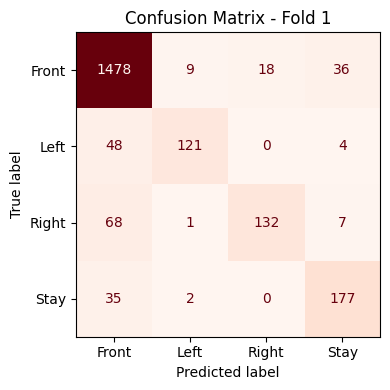


===== Fold 2 =====
Fold 2 best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

       Front     0.9037    0.9617    0.9318      1541
        Left     0.8929    0.7225    0.7987       173
       Right     0.8667    0.6875    0.7668       208
        Stay     0.8429    0.7523    0.7951       214

    accuracy                         0.8947      2136
   macro avg     0.8765    0.7810    0.8231      2136
weighted avg     0.8931    0.8947    0.8912      2136



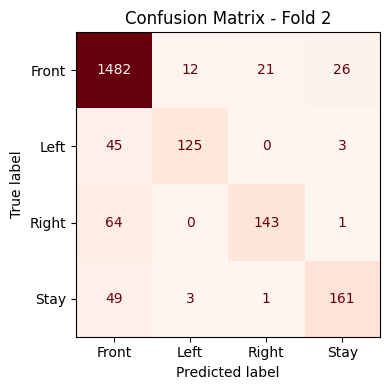


===== Fold 3 =====
Fold 3 best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

       Front     0.9113    0.9669    0.9382      1540
        Left     0.8571    0.7630    0.8073       173
       Right     0.9103    0.6794    0.7781       209
        Stay     0.8490    0.7617    0.8030       214

    accuracy                         0.9017      2136
   macro avg     0.8819    0.7927    0.8317      2136
weighted avg     0.9005    0.9017    0.8984      2136



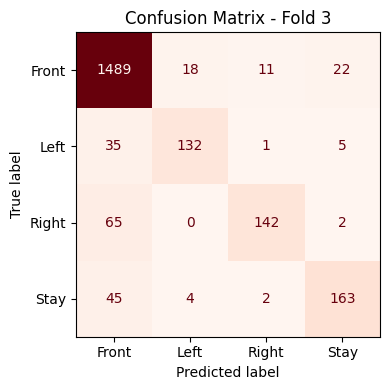


===== Fold 4 =====
Fold 4 best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

       Front     0.9119    0.9669    0.9386      1541
        Left     0.8889    0.7356    0.8050       174
       Right     0.8654    0.6490    0.7418       208
        Stay     0.8515    0.8075    0.8289       213

    accuracy                         0.9012      2136
   macro avg     0.8794    0.7898    0.8286      2136
weighted avg     0.8995    0.9012    0.8976      2136



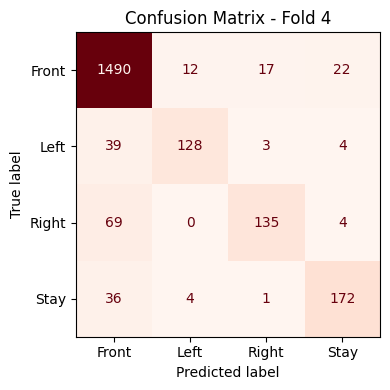

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n===== Fold {fold_idx} =====")
    X_trainval, y_trainval = X_flat[train_idx], y_flat[train_idx]
    X_test, y_test = X_flat[test_idx], y_flat[test_idx]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
    )

    # ✅ 자동 튜닝 설정
    param_grid = {
        'kernel': ['rbf', 'linear'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1]  # rbf에만 적용
    }

    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    print(f"Fold {fold_idx} best params:", grid.best_params_)

    # ✅ 테스트셋 평가
    preds = model.predict(X_test)
    targets = y_test

    cm = confusion_matrix(targets, preds, labels=range(len(label_encoder.classes_)))
    CM_total += cm
    preds_all.extend(preds)
    targets_all.extend(targets)

    print(classification_report(targets, preds, target_names=label_encoder.classes_, digits=4))

    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=ax, cmap='Reds', colorbar=False, values_format='d')
    ax.set_title(f'Confusion Matrix - Fold {fold_idx}')
    plt.tight_layout()
    plt.show()



=== Total confusion matrix ===


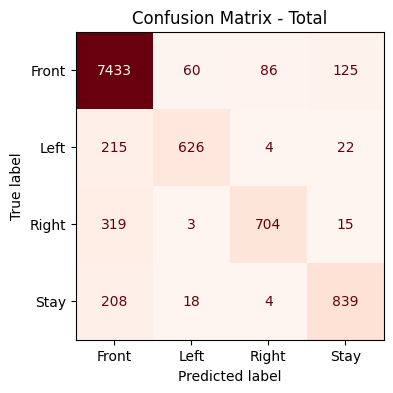

=== Total classification report ===
              precision    recall  f1-score   support

       Front     0.9092    0.9648    0.9362      7704
        Left     0.8854    0.7220    0.7954       867
       Right     0.8822    0.6763    0.7656      1041
        Stay     0.8382    0.7848    0.8106      1069

    accuracy                         0.8990     10681
   macro avg     0.8788    0.7870    0.8270     10681
weighted avg     0.8976    0.8990    0.8956     10681



In [6]:
print("\n=== Total confusion matrix ===")
fig, ax = plt.subplots(figsize=(4, 4))
disp_total = ConfusionMatrixDisplay(confusion_matrix=CM_total, display_labels=label_encoder.classes_)
disp_total.plot(ax=ax, cmap='Reds', colorbar=False, values_format='d')
plt.title("Confusion Matrix - Total")
plt.show()

print("=== Total classification report ===")
print(classification_report(targets_all, preds_all, target_names=label_encoder.classes_, digits=4))
